# Notebook 2: Analyzing phenotypic nonlinearity in synthetic data

---

><font size="3"> This is the second of three notebooks associated with the [pub](https://research.arcadiascience.com/pub/result-nonlinear-phenotypes/) "Harnessing genotype-phenotype nonlinearity to accelerate biological prediction".
>
><font size="3"> In the previous notebook (**Notebook 1**) we found that biological phenotypes frequently display nonlinear relationships. Here (**Notebook 2**), we will follow up on this observation by analyzing simulated phenotypes (generated using custom code availabe on [GitHub](https://github.com/Arcadia-Science/accounting-for-nonlinear-phenotypes)) that are associated with a range of possible genetic processes that might result in nonlinearity (e.g. pleiotropy and epistasis).
>   
><font size="3">All the data necessary for running this notebook are available via [Zenodo](https://zenodo.org/record/8298808). Please follow the code in **Notebook 1** to download before preceeding.

---

## Initiating workspace and loading data

<font size="3"> Set working directory.

In [1]:
library(here)
here::here() # Should be set to the root of the repository
setwd(here::here())

here() starts at /Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes



[1] "/Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes"

<font size="3"> Source functions.

In [2]:
suppressPackageStartupMessages(source('01_code/R/nonlinear_phenotype_utils.R'))

><font size="3"> To better assess how genetic processes might effect phenotypic relationships, we created a set of simulated phenotypes. To do so, we generated n random genotypes from a probability distribution for a given number of individuals (see [pub](https://research.arcadiascience.com/pub/result-nonlinear-phenotypes/) for a more in-depth description). Each genotype could influence an output phenotype given a set probability distribution and could interact with others via a predefined probability. We also allowed the resulting polyphenotypes to correlate given a certain probability, letting us vary the amount of epistasis (probability of gene-gene interactions) and pleiotropy (probability of phenotype-phenotype interactions) in the data. 
>   
><font size="3">Using this approach, we generated a data set in which all combinations of epistatic and pleiotropic probabilities were considered (from P = 0 to P = 1, 0.01 increments). This produced a final set of 10,201 polyphenotypes, each containing 20 synthetic phenotypes measured across 600 simulated individuals.

---

<font size="3"> Load simulated phenotype data. These data are included in the Zenodo archive that is downloaded in **Notebook 1**. If you haven't already, follow the code in **Notebook 1** to download this dataset.

In [3]:
# Load pickle
phens <- pd$read_pickle("data/phen_pleio_int_01_0_1.pk")

<font size="3"> Combine phenotype vectors into matrices.

In [4]:
# Combine phenotypes into matrices
phenos <- list()

# Generate naming vectors
p_pleio <- paste(rep("pleio", length(seq(0, 1, 0.01))), seq(0, 1, 0.01), sep = "")
p_int <- paste(rep("int", length(seq(0, 1, 0.01))), seq(0, 1, 0.01), sep = "")

# Combine phenotypes into matrices
for (i in 1:length(phens)) {
  for (j in 1:length(phens[[i]])) {
    phenos[[paste(p_pleio[i], p_int[j], sep = "_")]] <- do.call(cbind, phens[[i]][[j]])
  }
}

## Calculating and comparing entropy

><font size="3"> In the previous notebook we found that the frequency of nonlinearity varied across empirical datasets. These patterns may be reflective of a variety of phenomena: the complexity of genetic processes underlying the observed phenotypes, the inherent biological structure of the phenotypes themselves, experimental variability, etc. Given this variety, we reasoned it would useful to develop measures that could further characterize the nature of phenotypic interactions.
>
><font size="3"> We decided to employ concepts from information theory (e.g. **entropy**) to begin to explore how the iformation content of phenotypic sets (what we call **polyphenotypes** in the pub) might relate to other aspects of biology such as pleiotropy or gene-gene interactions.
>
><font size="3"> For each set of phenotypes, entropy is calculated by first computing the “generalized variance” (the determinant of the variance-covariance matrix). We then extract a single-vector descriptor by calculating the eigenvector of the generalized variance matrix using spectral decomposition. We can then calculate the entropy of the leading eigenvector, generating a singular measure of information content for each polyphenotype.
>    
><font size="3"> We reason that entropy may be informative in multiple ways. First, overall entropy reflects the interrelatedness of polyphenotypes. Lower values may reflect a set of phenotypes that are driven by the same underlying biology (e.g., multiple, correlated measurements of a trait such as finger length). On the other hand, higher values may indicate that polyphenotype data contain measurements from multiple, orthogonal features of biology (e.g., finger length and education level).
>  
><font size="3"> The second way entropy may be informative is through its distribution across different portions of a polyphenotype. Consider the case of completely orthogonal phenotypes. If we select random combinations of orthogonal phenotypes and measure their entropy, it should be the case that entropy proportionally increases as we analyze larger and larger sets of phenotypes (i.e., more new information is being added with each increase in the number of randomly chosen phenotypes). In contrast, for a set of strongly correlated phenotypes (e.g., in the case of pleiotropy), one should expect entropy to stay constant as we analyze larger sets of the phenotypes (i.e., no new information is added).

---

<font size="3"> In this code chunk, we will calculate entropy as outlined above over a range of data proportions (from 10% of individuals in the dataset to 90%) to see if there are consistent patterns across different probabilities of pleiotropy and gene-gene interactions. 
   
<font size="3">**Note:** Here, in this chunk we are only calculating entropy for polyphenotypes in which the probability of gene-gene interaction = 0 to explicitly test the relationship between pleiotropy and entropy. We fill calculate entropy for the full set in a later section.

In [7]:
# Split phenotype data as a function of interaction probability
p <- split(phenos, p_int)

# Calculate subsampled entropy for each probability
all_entropies <- list()

# Set counter 
pb <- txtProgressBar(min = 1,
                     max = length(p$int0),
                     style = 3,
                     width = 100,
                     char = ".")

# Loop through and calculate entropy
for (i in 1:length(p$int0)) {
  # Update counter
  setTxtProgressBar(pb, i)
  # Calculate subsampled entropy using 'subsample.entropy'
  all_entropies[[names(p$int0)[i]]] <- suppressWarnings(subsample.entropy(p$int0[[i]],
    numBins = 100,
    permutations = 1000,
    normalize_entropy = FALSE,
    sample_sizes = seq(0.1, 0.9, 0.05)
  ))
}

  |..................................................| 100%

<font size="3"> Plot the distribution of entropy as a function of sample size.

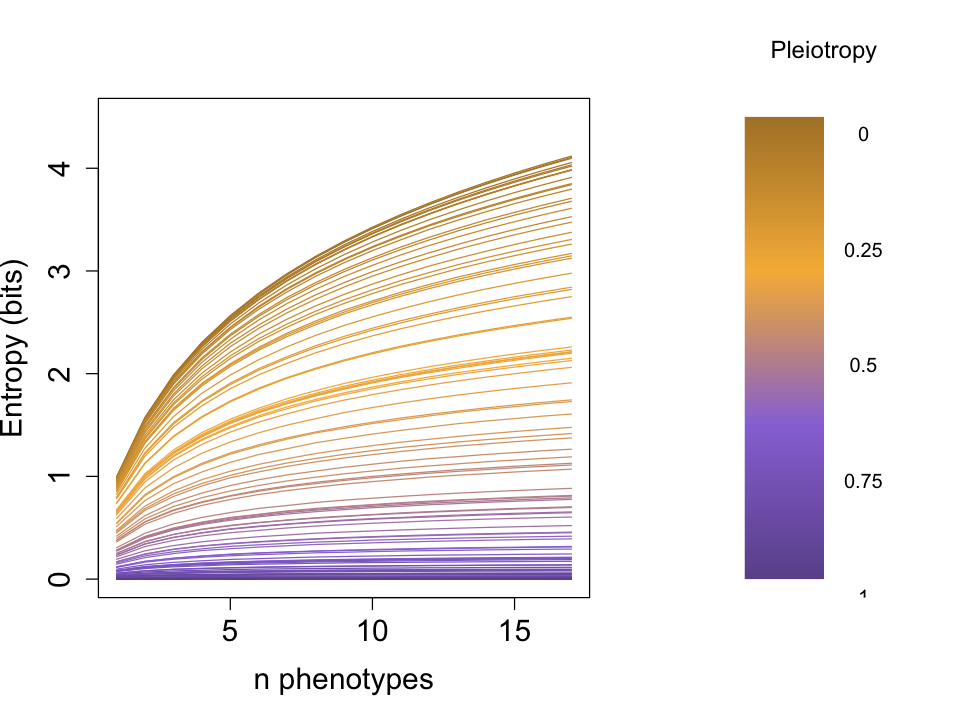

In [8]:
# Set up plot
options(repr.plot.width=8, repr.plot.height=6)
layout(matrix(1:2, ncol = 2), width = c(2, 1), height = c(1, 1))

# Set colors
cols <- rev(colorRampPalette(c(darken_color(arcadia.pal(n = 6, name = 'Accent')[5]),
                               arcadia.pal(n = 6, name = 'Accent')[5],
                               arcadia.pal(n = 6, name = 'Accent')[4],
                               darken_color(arcadia.pal(n = 6, name = 'Accent')[4])))(length(all_entropies)))

# Plot
plot(colMeans(do.call(cbind, all_entropies[[1]]$entropies)),
  type = "l",
  ylim = c(0, 4.5),
  col = cols[1],
  ylab = "Entropy (bits)",
  xlab = "n phenotypes",
  cex.axis = 1.5,
  cex.lab = 1.5
)
for (i in 2:length(all_entropies)) {
  lines(colMeans(do.call(cbind, all_entropies[[i]]$entropies)), col = cols[i])
}

# Add legend
legend_image <- as.raster(matrix(cols, ncol = 1))
plot(c(0, 2), c(0, 1), type = "n", axes = F, xlab = "", ylab = "", main = "Pleiotropy", font.main = 1)
text(x = 1.5, y = rev(seq(0, 1, l = 5)), labels = seq(0, 1, l = 5), pos = 1)
rasterImage(legend_image, 0, 0, 1, 1)

<font size="3"> Calculate the slope of the entropy distribution for each pleiotropy probability.

In [9]:
# Generate empty vector to save results into
slopes <- c()
# Loop and calculate
for (i in 1:length(all_entropies)) {
  # Calculate column-wise entropy mean (spanning phenotype n)
  y <- colMeans(do.call(cbind, all_entropies[[i]]$entropies))
  # Compute slopes for each
  slopes <- c(slopes, coef(lm(y ~ seq(1, length(y), 1)))[2])
}

<font size="3"> Plot entropy slope as a function of pleiotropy probability.

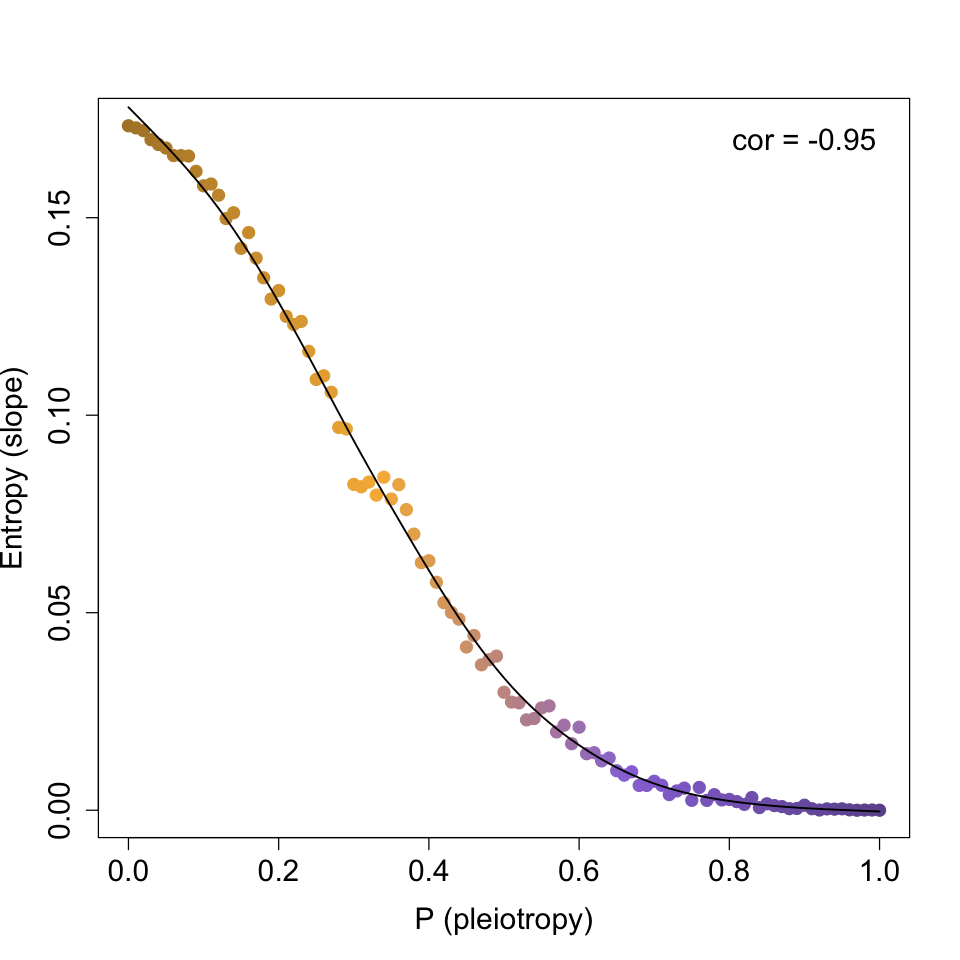

In [10]:
# Set up plot
options(repr.plot.width=8, repr.plot.height=8)

# Set colors
cols <- rev(colorRampPalette(c(darken_color(arcadia.pal(n = 6, name = 'Accent')[5]),
                               arcadia.pal(n = 6, name = 'Accent')[5],
                               arcadia.pal(n = 6, name = 'Accent')[4],
                               darken_color(arcadia.pal(n = 6, name = 'Accent')[4])))(length(all_entropies)))

# Fit slopes and pleiotropy probability with a spline
a <- smooth.spline(seq(0, 1, 0.01),
  slopes,
  spar = 0.75
)$y

# Plot
plot(seq(0, 1, 0.01),
     slopes,
     pch = 20,
     cex = 2,
     col = cols,
     cex.axis = 1.5,
     cex.lab = 1.5,
     xlab = 'P (pleiotropy)',
     ylab = 'Entropy (slope)')
lines(seq(0, 1, 0.01), a, lwd = 1.5)
text(0.9, 
     0.17, 
     paste('cor =', round(cor(seq(0, 1, 0.01), slopes), 2)),
     cex = 1.5)

## Compare nonlinearity across probabilities

><font size="3"> So far, we have found some interesting relationships between entropy, data set size, and the probability of pleiotropy. In this section, we will continue to expand these observations by calculating the frequency of nonlinearity and compare it to entropy. 

---

<font size="3"> Calculate nonlinearity for all combinations of pleiotropy and gene interaction probability.

In [13]:
# Set counter
pb <- txtProgressBar(min = 1,
                     max = length(phenos),
                     style = 3,
                     width = 100,
                     char = ".")

# Generate empty list to save results into
res <- list()

# Loop and calculate
for (i in 1:length(phenos)) {
  # Update counter
  setTxtProgressBar(pb, i)
  # Calculate nonlinearity statistics using 'compare_nonlinear'
  res[[as.character(i)]] <- compare_nonlinear(phenos[[i]], return_models = TRUE)
}

  |....................................................................................................| 100%

<font size="3"> Calculate AIC differences.

In [14]:
# Calculate AIC differences
a <- c()
for (i in 1:length(res)) {
  tmp <- unlist(lapply(res[[i]]$models, function(x) abs(x$AIC[2, 2]) - abs(x$AIC[1, 2])))
  a <- c(a, sum(tmp < 0) / length(tmp))
}

# Split
a <- split(a, p_int)

<font size="3"> Smooth each AIC difference distribution.

In [15]:
a_smooth <- lapply(a, function(x) smooth.spline(1:length(x), x, spar = 0.75)$y)

<font size="3"> Plot.

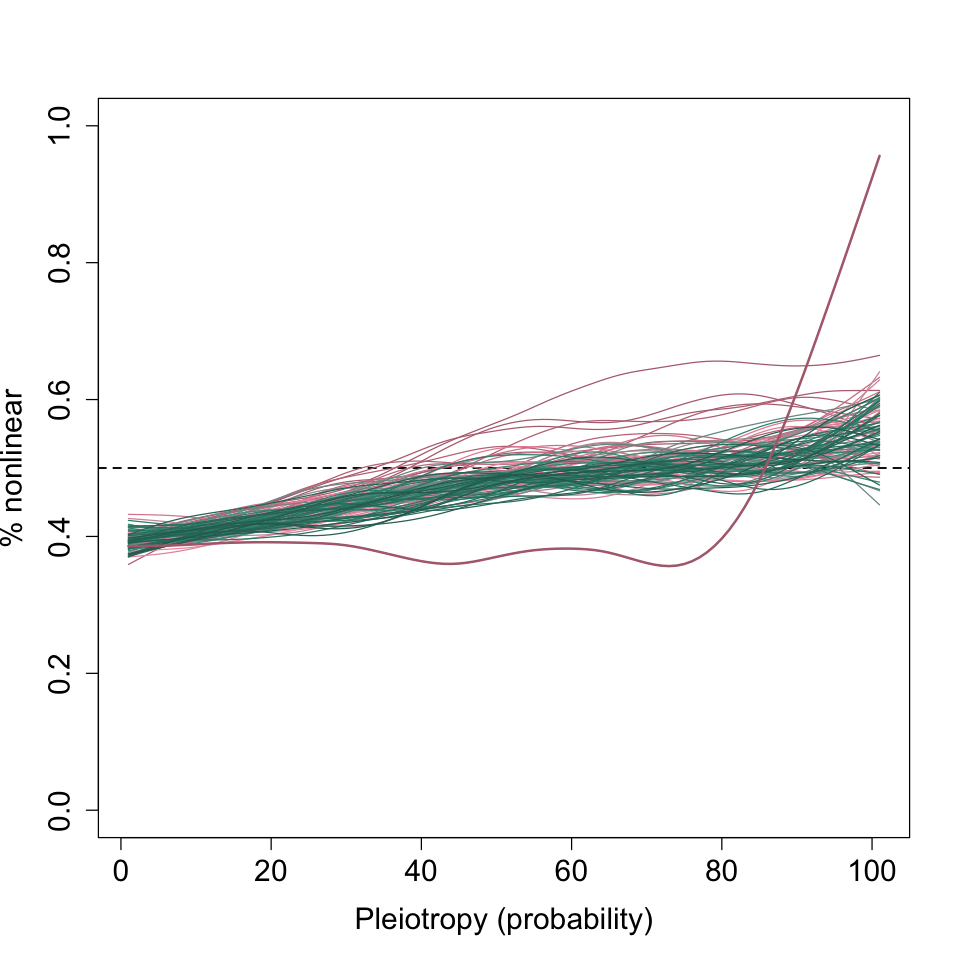

In [18]:
# Set colors
cols <- rev(colorRampPalette(c(darken_color(arcadia.pal(n = 6, name = 'Accent')[3]),
                               arcadia.pal(n = 6, name = 'Accent')[3],
                               arcadia.pal(n = 6, name = 'Accent')[6],
                               darken_color(arcadia.pal(n = 6, name = 'Accent')[6])))(length(a_smooth)))
# Plot
plot(a_smooth[[1]],
  type = "l",
  ylim = c(0, 1),
  col = cols[1],
  ylab = "% nonlinear",
  xlab = "Pleiotropy (probability)",
  cex.axis = 1.5,
  cex.lab = 1.5
)
abline(h = 0.5, lwd = 1.5, lty = "dashed")
for (i in 2:length(a_smooth)) {
  lines(a_smooth[[i]], col = cols[i])
}
lines(a_smooth[[1]], lwd = 2, col = cols[1])

## Compare nonlinearity and entropy across all probabilities

<font size="3"> Calculate subsampled entropy for all probability combinations.

In [20]:
# Calculate subsampled entropy for all phenotypes using lapply
full_entropies <- lapply(p, function(x) {
  lapply(x, function(z) {
    suppressWarnings(subsample.entropy(z,
      numBins = 100,
      permutations = 100,
      normalize_entropy = FALSE,
      sample_sizes = seq(0.1, 0.9, 0.1)
      )
    )
  })
})

<font size="3"> Fit slopes.

In [21]:
slopes <- lapply(full_entropies, function(x) {
  lapply(x, function(z) {
    y <- colMeans(do.call(cbind, z$entropies))
    coef(lm(y ~ seq(1, length(y), 1)))[2]
  })
})

<font size="3"> Compare entropy slope and nonlinearity across all probability combinations.

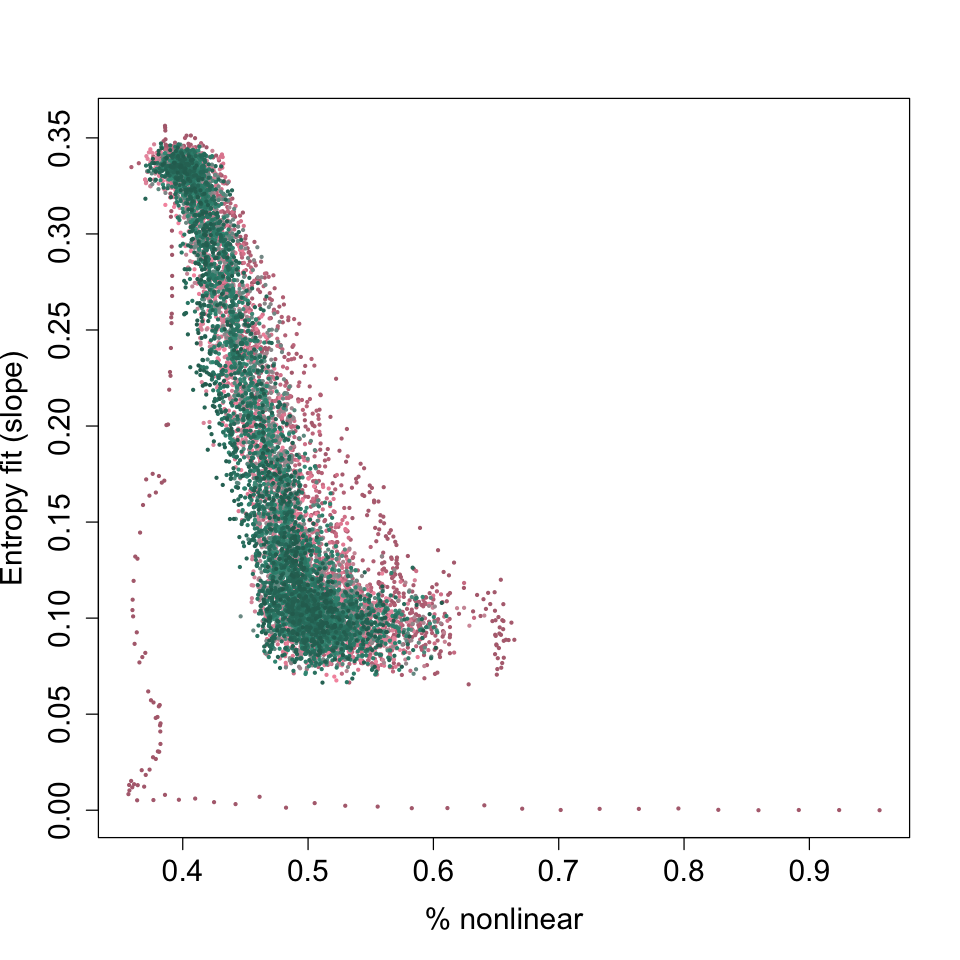

In [24]:
# Set colors
cols <- rev(colorRampPalette(c(darken_color(arcadia.pal(n = 6, name = 'Accent')[3]),
                               arcadia.pal(n = 6, name = 'Accent')[3],
                               arcadia.pal(n = 6, name = 'Accent')[6],
                               darken_color(arcadia.pal(n = 6, name = 'Accent')[6])))(length(unlist(a_smooth))))

# Plot
plot(unlist(a_smooth),
  unlist(slopes),
  xlab = "% nonlinear",
  ylab = "Entropy fit (slope)",
  cex.lab = 1.5,
  cex.axis = 1.5,
  cex = 0.5,
  pch = 20,
  col = cols
)